<a href="https://colab.research.google.com/github/andrewsiyoon/spiking-seRNN/blob/main/seRSNN_SHD_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**seRSNN: How to spatially-embed a recurrent spiking neural network**
In this notebook, we demonstrate how to spatially-embed a recurrent spiking neural network and train it on a classic neuromorphic classification task for spiking models. We hope to provide this framework, which applies biologically-inspired spatial and communicability constraints to RSNNs, for open-access use by researchers in the field.

In [1]:
#Install packages -----

'''
snnTorch is a package that provides gradient-based learning for spiking neural networks and integrates various spiking neuron models with the PyTorch framework.
Tonic is a package designed specifically for downloading, extracting, and manipulating various neuromorphic datasets.
'''

!pip install -q 'snntorch == 0.6.1'
!pip install -q 'tonic == 1.2.5'
!pip install -q ipython-autotime
%load_ext autotime
!pip install -q bctpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.7/95.7 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
time: 5.34 s (started: 2023-04-11 16:05:01 +00:00)


In [2]:
#Import packages -----

import torch, torch.nn as nn
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import surrogate
import snntorch.functional as SF

import numpy as np

import scipy
from scipy.stats import pearsonr

import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset

import random

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
import pandas as pd

import bct

time: 9.89 s (started: 2023-04-11 16:05:07 +00:00)


In [3]:
#Set random seeds -----

np.random.seed(180139)
torch.manual_seed(347932)

time: 6.25 ms (started: 2023-04-11 16:05:17 +00:00)


## Preparing the SHD dataset

In [4]:
#Download and extract SHD dataset -----

'''
Parameters are adapted from the original SHD paper.
'''

#Define variables (batch size, sensor size)
batch_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sensor_size = tonic.datasets.SHD.sensor_size

#Define transformations
frame_transform = transforms.Compose([transforms.ToFrame(sensor_size=sensor_size, n_time_bins = 200), transforms.DropEvent(p = 0.001)])

#Define training and test sets
SHD_train = tonic.datasets.SHD(save_to='./data', transform=frame_transform, train=True)
SHD_test = tonic.datasets.SHD(save_to='./data', transform=frame_transform, train=False)

#Create dataloaders
trainloader = DataLoader(SHD_train, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle = True, drop_last = True)
testloader = DataLoader(SHD_test, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle = True, drop_last = True)

  0%|          | 0/130863613 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_train.h5.zip to ./data/SHD


  0%|          | 0/38141465 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_test.h5.zip to ./data/SHD
time: 21.5 s (started: 2023-04-11 16:05:17 +00:00)


##Initialize membrane time constants

In [5]:
#Initialize membrane time constant distribution -----

'''
This section defines two functions: a clipping function and an initialization function. Membrane parameters are taken from Perez-Nieves et al. in order to standardize network comparisons.
'''

#Membrane parameters
tau_mem = 20e-3
dist_shape = 3
time_step = 0.5e-3

#Clipping function
def clip_tc(x):
    clipped_tc = x.clamp_(0.7165, 0.995)
    return clipped_tc

#Initialize membrane time constant distribution
def init_tc():
    dist_gamma = np.random.gamma(dist_shape, tau_mem / 3, 100)
    dist_beta = torch.from_numpy(np.exp(-time_step / dist_gamma))
    clipped_beta = clip_tc(dist_beta)
    return clipped_beta

time: 1.46 ms (started: 2023-04-11 16:05:38 +00:00)


##Model architecture

We define the recurrent spiking neural network in this section. The snnTorch package is used to instantiate unit neurons as recurrent LIF models (for the hidden layer) and LIF models (for the readout layer). PyTorch is used to create the linear connections between layers.

In [6]:
#Size parameters
num_inputs = 700
num_hidden = 100
num_outputs = 20

#Network parameters
het_tau = init_tc().to(device)
hom_tau = 0.9753

#Optimization mechanism
spike_grad = surrogate.fast_sigmoid(slope = 100)

#Model definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.RLeaky(beta = het_tau, linear_features = num_hidden, learn_beta = True, spike_grad = spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta = hom_tau, spike_grad = spike_grad)

    def forward(self, x):

        #Initialize parameters
        spk1, mem1 = self.lif1.init_rleaky()
        mem2 = self.lif2.init_leaky()

        #Record recurrent layer
        spk1_rec = []
        mem1_rec = []

        #Record readout layer
        spk2_rec = []
        mem2_rec = []
        
        #Forward loop
        for step in range(data.size(0)):
            batched_data = data[step].view(batch_size, num_inputs)
            cur1 = self.fc1(batched_data)
            spk1, mem1 = self.lif1(cur1, spk1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            #Save recurrent and readout data
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        #Convert saved data to tensors
        spk1_rec = torch.stack(spk1_rec)
        mem1_rec = torch.stack(mem1_rec)

        spk2_rec = torch.stack(spk2_rec)
        mem2_rec = torch.stack(mem2_rec)
        
        return spk2_rec, mem2_rec, spk1_rec, mem1_rec

net = Net().to(device)

time: 4.56 s (started: 2023-04-11 16:05:38 +00:00)


In [7]:
#Extract membrane time constants (pre-training) -----

tc_hist = []
pretrain_tau = (-time_step / np.log(het_tau.cpu())) / 1e-3
tc_hist.append(pretrain_tau.numpy())

time: 15.5 ms (started: 2023-04-11 16:05:43 +00:00)


In [8]:
#Optimizer and loss function -----

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, betas = (0.9, 0.999))
loss_fn = SF.ce_max_membrane_loss()

time: 702 µs (started: 2023-04-11 16:05:43 +00:00)


In [9]:
#Distance matrix -----
network_structure = [5, 5, 4]
distance_metric = 'euclidean'
distance_power = 1

#Define each dimension's neurons
nx = np.arange(network_structure[0])
ny = np.arange(network_structure[1])
nz = np.arange(network_structure[2])

#Create coordinate grid
[x,y,z] = np.meshgrid(nx,ny,nz)
coordinates = [x.ravel(),y.ravel(),z.ravel()]

#Calculate Euclidean distance matrix
euclidean_vector = scipy.spatial.distance.pdist(np.transpose(coordinates), metric=distance_metric)
euclidean = scipy.spatial.distance.squareform(euclidean_vector**distance_power)
distance_matrix = euclidean.astype('float64')

#Create tensor from distance matrix
distance_matrix = torch.from_numpy(distance_matrix).to(device)

time: 2.74 ms (started: 2023-04-11 16:05:43 +00:00)


In [10]:
#Diagnostic tests -----

#Test for spatial regularization
def test_euclidean(x, y):
    x = torch.abs(x)
    x_array = x.detach().cpu().numpy()
    flat_x_array = x_array.flatten()
    y = torch.abs(y)
    y_array = y.detach().cpu().numpy()
    flat_y_array = y_array.flatten()
    correlation = pearsonr(flat_x_array, flat_y_array)[0]
    return correlation

print(f"Initial, pre-training correlation between distance and weight matrices (should be approx. 0): {test_euclidean(distance_matrix, net.lif1.recurrent.weight)}")

Initial, pre-training correlation between distance and weight matrices (should be approx. 0): -0.016351912685894438
time: 15.7 ms (started: 2023-04-11 16:05:43 +00:00)


In [11]:
#Training parameters
num_epochs = 50
comms_factor = 1

#Regularization parameters
regu_strength = 1e-5

#Initialize variables of interest
train_loss_hist = []
spk_acc_hist = []
mem_acc_hist = []
rec_tot_hist = []
corr_hist = []
test_acc_hist = []
test_loss_hist = []

#Initialize hidden/readout layer attributes
spk_rec_hist = []
mem_rec_hist = []
spk_out_hist = []
mem_out_hist = []

#Pre-training extractions
rec_tot_hist.append(torch.sum(torch.abs(net.lif1.recurrent.weight.detach())))
corr_hist.append(test_euclidean(distance_matrix, net.lif1.recurrent.weight))

#Training loop
for epoch in range(1, num_epochs + 1):
    correct_train = 0
    total_train = 0
    for i, (data, targets) in enumerate(iter(trainloader)):

        #Load data on CUDA
        data = data.to(device)
        targets = targets.to(device)

        #Set model to training mode
        net.train()
        spk_out, mem_out, spk_rec, mem_rec = net(data)

        #Calculate loss
        loss_val = loss_fn(mem_out, targets) 

        #Gradient calculation and weight updates
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        #clip_tc(net.lif1.beta.detach())

        #Save loss history
        train_loss_hist.append(loss_val.item())

        #New training accuracy
        _, predicted_train = mem_out.sum(dim=0).max(1)
        correct_train += (predicted_train == targets).sum().item()
        total_train += targets.size(0)

        #Save recurrent spikes/potentials
        #sum_spk_rec = spk_rec.sum(0)
        #sum_mem_rec = mem_rec.sum(0)
        #summed_spk_rec = sum_spk_rec.sum(0)
        #summed_mem_rec = sum_mem_rec.sum(0)

        #spk_rec_hist.append(summed_spk_rec)
        #mem_rec_hist.append(summed_mem_rec)

        #Save readout spikes/potentials
        #sum_spk_out = spk_out.sum(0)
        #sum_mem_out = mem_out.sum(0)
        #summed_spk_out = sum_spk_out.sum(0)
        #summed_mem_out = sum_mem_out.sum(0)

        #spk_out_hist.append(summed_spk_out)
        #mem_out_hist.append(summed_mem_out)

    #Evaluations (every epoch)
    net.eval()

    #Training accuracy (spike rate)
    spk_acc = SF.accuracy_rate(spk_out, targets)
    spk_acc_hist.append(spk_acc)

    #Training accuracy (membrane potential)
    mem_acc = correct_train/total_train
    mem_acc_hist.append(mem_acc)

    #Sum of recurrent weights
    rec_tot = torch.sum(torch.abs(net.lif1.recurrent.weight.detach()))
    rec_tot_hist.append(rec_tot)

    #Correlation of distance and weight matrices
    corr_matrix = test_euclidean(distance_matrix, net.lif1.recurrent.weight.detach())
    corr_hist.append(corr_matrix)

    #Save time constants
    converted_tc = (-time_step / np.log(net.lif1.beta.detach().cpu())) / 1e-3
    tc_hist.append(converted_tc.numpy())

    #Validation accuracy
    with torch.no_grad():
        total = 0
        correct = 0
        net.eval()

        for data, targets in iter(testloader):
            data = data.to(device)
            targets = targets.to(device)

            test_spk, test_mem, _, _ = net(data)
            _, predicted = test_mem.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            test_loss = loss_fn(test_mem, targets)

        test_acc_hist.append(correct / total)
        test_loss_hist.append(test_loss.item())

    #Print statements
    if epoch % 1 == 0:
        print(f"Epoch {epoch}/{num_epochs} === Train loss: {loss_val.item():.2f} --- ", end = "")
        print(f"Spike accuracy: {spk_acc * 100:.2f}% --- ", end = "")
        print(f"Mem. potential accuracy: {mem_acc * 100:.2f}% --- ", end = "")
        print(f"Val. loss: {test_loss.item():.2f} --- ", end = "")
        print(f"Val. accuracy: {100 * correct / total:.2f}%\n")

Epoch 1/50 === Train loss: 2.88 --- Spike accuracy: 11.72% --- Mem. potential accuracy: 5.95% --- Val. loss: 2.88 --- Val. accuracy: 5.24%

Epoch 2/50 === Train loss: 2.94 --- Spike accuracy: 17.19% --- Mem. potential accuracy: 9.02% --- Val. loss: 2.91 --- Val. accuracy: 11.40%

Epoch 3/50 === Train loss: 2.79 --- Spike accuracy: 10.16% --- Mem. potential accuracy: 10.53% --- Val. loss: 2.68 --- Val. accuracy: 8.59%

Epoch 4/50 === Train loss: 2.49 --- Spike accuracy: 31.25% --- Mem. potential accuracy: 15.62% --- Val. loss: 2.60 --- Val. accuracy: 22.38%

Epoch 5/50 === Train loss: 2.30 --- Spike accuracy: 25.00% --- Mem. potential accuracy: 23.92% --- Val. loss: 2.53 --- Val. accuracy: 29.18%

Epoch 6/50 === Train loss: 1.85 --- Spike accuracy: 23.44% --- Mem. potential accuracy: 25.82% --- Val. loss: 2.39 --- Val. accuracy: 28.40%

Epoch 7/50 === Train loss: 1.48 --- Spike accuracy: 25.00% --- Mem. potential accuracy: 35.85% --- Val. loss: 2.14 --- Val. accuracy: 42.37%

Epoch 8/50

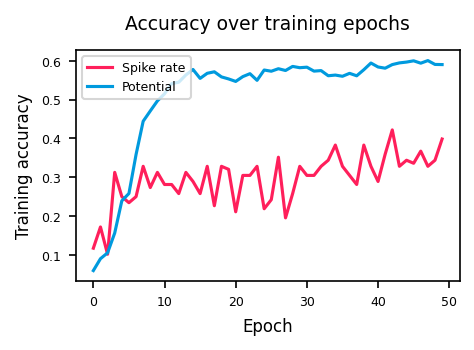

time: 651 ms (started: 2023-04-11 17:35:53 +00:00)


In [17]:
#Training accuracy
plt.figure(figsize=(3.3,2),dpi=150)
#spk_acc_hist.insert(0, 0)
#mem_acc_hist.insert(0, 0)
plt.plot(spk_acc_hist, color = '#ff1f5b', label = 'Spike rate')
plt.plot(mem_acc_hist, color = '#009ade', label = 'Potential')
plt.legend(loc = 'upper left', fontsize=6)
plt.xlabel('Epoch', fontsize = 8)
plt.ylabel('Training accuracy', fontsize = 8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Accuracy over training epochs', fontsize = 9, pad = 10);

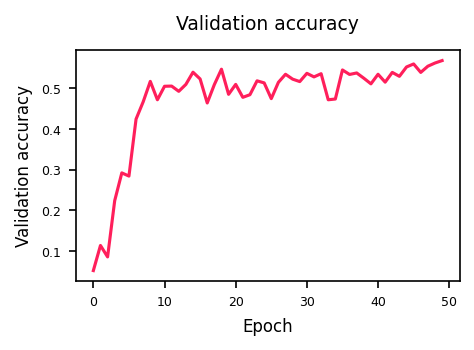

time: 305 ms (started: 2023-04-11 17:36:41 +00:00)


In [18]:
#Validation accuracy
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(test_acc_hist, color = '#ff1f5b')
plt.xlabel('Epoch', fontsize = 8)
plt.ylabel('Validation accuracy', fontsize = 8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Validation accuracy', fontsize = 9, pad = 10);

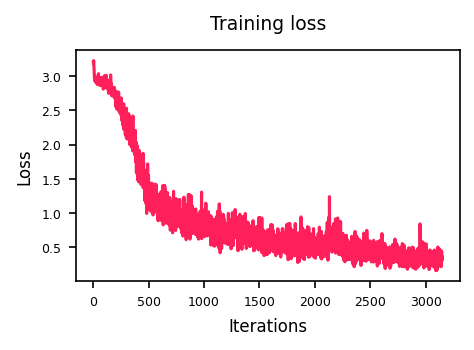

time: 369 ms (started: 2023-04-11 17:39:02 +00:00)


In [22]:
#Loss curves
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(train_loss_hist, color = '#ff1f5b', label = 'Training')
#plt.plot(test_loss_hist, color = '#009ade', label = 'Validation')
#plt.legend(loc = 'upper left', fontsize=6)
plt.xlabel('Iterations', fontsize = 8)
plt.ylabel('Loss', fontsize = 8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Training loss', fontsize = 9, pad = 10);